# Particle position detection accuracy tests

Outdated centroid detection method, but contains some plots for feature map representation.

## Load data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset class to make it compatible with the DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# dataset1
dataset = torch.load('data/dataset_C.pt')

train_dataset_C = dataset['train']
test_dataset_C = dataset['test']

train_dataloader_C = DataLoader(train_dataset_C, batch_size=8, shuffle=True)
test_dataloader_C = DataLoader(test_dataset_C, batch_size=8, shuffle=False)

# dataset2
dataset = torch.load('data/dataset_CE.pt')

train_dataset_CE = dataset['train']
test_dataset_CE = dataset['test']

train_dataloader_CE = DataLoader(train_dataset_CE, batch_size=8, shuffle=True)
test_dataloader_CE = DataLoader(test_dataset_CE, batch_size=8, shuffle=False)

In [2]:
images_C, _, positions_C = zip(*test_dataset_C)
images_C = torch.stack(images_C)
positions_C = torch.stack(positions_C)

In [3]:
images_CE, _, _, positions_CE_C, positions_CE_E = zip(*test_dataset_CE)
images_CE = torch.stack(images_CE)
positions_CE_C = torch.stack(positions_CE_C)
positions_CE_E = torch.stack(positions_CE_E)

## Architecture and training

In [4]:
from typing import Callable, Optional

import numpy as np
import scipy
import scipy.ndimage
import torch
import torch.nn as nn
from skimage import morphology

from deeplay import ConvolutionalNeuralNetwork, Application

from deeplay.applications.detection.lodestar.transforms import (
    RandomRotation2d,
    RandomTranslation2d,
    Transforms,
)

import torch.nn.functional as F

class LodeSTAR(Application):

    # num_outputs: int # only 2D for now
    num_classes: int
    transforms: Transforms
    n_transforms: int
    model: nn.Module
    between_loss: Callable
    within_loss: Callable
    between_loss_weight: float
    within_loss_weight: float

    def __init__(
        self,
        model: Optional[nn.Module] = None,
        num_classes: int = 2,
        transforms: Optional[Transforms] = None,
        n_transforms: int = 2,
        between_loss: Optional[Callable] = None,
        within_loss: Optional[Callable] = None,
        between_loss_weight: float = 1,
        within_loss_weight: float = 10,
        **kwargs
    ):
        if transforms is None:
            transforms = Transforms(
                [
                    RandomTranslation2d(),
                    RandomRotation2d(),
                ]
            )

        self.num_classes = num_classes
        self.transforms = transforms
        self.n_transforms = n_transforms
        self.model = model or self._get_default_model()
        self.between_loss = between_loss or nn.L1Loss(reduction="mean")
        self.within_loss = within_loss or nn.L1Loss(reduction="mean")
        self.between_loss_weight = between_loss_weight
        self.within_loss_weight = within_loss_weight

        self.losses = {
            'between_image_disagreement': [],
            'within_image_disagreement': [],
            'mask_loss': []
        }

        super().__init__(loss=self.compute_loss, **kwargs)

    def _get_default_model(self):
        cnn = ConvolutionalNeuralNetwork(
            None,
            [32, 32, 64, 64, 64, 64, 64, 64, 64],
            (2 + 1) + (self.num_classes + 1),  # (num_outputs + 1) + (num_classes +1)
        )
        cnn.blocks[2].pooled()

        return cnn

    def transform_data(self, batch):
        repeated = batch.repeat_interleave(self.n_transforms, dim=0)
        transformed, inverse = self.transforms(repeated)
        return transformed, inverse

    def forward(self, x):

        if self.training:
            x, class_label = x

        out = self.model(x)
        y = out[:, :3, ...]
        classes=out[:, 3:, ...]
        classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1)

        batch_size = classes.size(0)
        num_channels = classes.size(1)
        _, _, Hx, Wx = x.shape
        _, _, Hy, Wy = y.shape
        x_range = torch.arange(Hy, device=x.device) * Hx / Hy
        y_range = torch.arange(Wy, device=x.device) * Wx / Wy
        
        if self.training:
            x_range = x_range - Hx / 2 + 0.5
            y_range = y_range - Wx / 2 + 0.5

            batch_indices = torch.arange(batch_size)

            mask = classes[batch_indices,  class_label.squeeze(), :, :][:,None]
        else:
            
            mask = classes.sum(dim=1)[:,None]#torch.ones_like(y[:, 2:3, ...])


        Y, X = torch.meshgrid(y_range, x_range, indexing="xy")

        delta_x = y[:, 0:1, ...]
        delta_y = y[:, 1:2, ...]
        yy = y[:, 2:3, ...]
        weights = y[:, 2:3, ...].sigmoid()
        X = X + delta_x
        Y = Y + delta_y
        
        return torch.cat(
            [X, Y, weights, mask, classes], dim=1
        )

    def normalize(self, weights):
        weights = weights + 1e-5
        return weights / weights.sum(dim=(2, 3), keepdim=True)

    def reduce(self, X, weights):
        return (X * weights).sum(dim=(2, 3)) / weights.sum(dim=(2, 3))

    def compute_loss(self, y_hat, inverse_fn):
        B = y_hat.size(0) / self.n_transforms

        y_pred, weights, mask_gumbel, classes = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:4], y_hat[:, 4:]
        
        weights =  mask_gumbel
        weights = self.normalize(weights)
        y_reduced = self.reduce(y_pred, weights)

        within_disagreement = (y_pred - y_reduced[..., None, None]) * weights 
        within_disagreement_loss = self.within_loss(
            within_disagreement, torch.zeros_like(within_disagreement)
        )

        y_reduced_on_initial = inverse_fn(y_reduced)

        between_disagreement_loss = 0

        for i in range(0, y_pred.size(0), self.n_transforms):
            batch_preds = y_reduced_on_initial[i : i + self.n_transforms]
            batch_mean_pred = batch_preds.mean(dim=0, keepdim=True).expand_as(
                batch_preds
            )
            between_disagreement_loss += (
                self.between_loss(batch_preds, batch_mean_pred) / B
            )
        weighted_between_loss = between_disagreement_loss * self.between_loss_weight
        weighted_within_loss = within_disagreement_loss * self.within_loss_weight
        
        compl_mask=classes[:,:-1,...].sum(dim=1)[:,None]-mask_gumbel
        mask_loss = 10*compl_mask.mean(dim=(2, 3)).mean()

        self.save_losses({
            'between_image_disagreement': weighted_between_loss.item(),
            'within_image_disagreement': weighted_within_loss.item(),
            'mask_loss': mask_loss.item()
        })

        return {
            "between_image_disagreement": weighted_between_loss,
            "within_image_disagreement": weighted_within_loss,
            "mask_loss": mask_loss
        }

    def save_losses(self, current_losses):
        for key, value in current_losses.items():
            self.losses[key].append(value)

    def get_losses(self):
        return self.losses

    def plot_losses(self):
        import matplotlib.pyplot as plt

        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training Losses')
        for ax, (key, values) in zip(axs.ravel(), self.losses.items()):
            ax.plot(values)
            ax.set_title(key)
            ax.set_xlabel('Iterations')
            ax.set_ylabel('Loss')
        plt.tight_layout()
        plt.show()

    def on_train_end(self) -> None:
        self.eval()
        self.plot_losses()
        return super().on_train_end()

    def detect(self, x, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile", min_distance=10):
        """Detects objects in a batch of images

        Parameters
        ----------
        x : array-like
            Input to model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        y = self(x.to(self.device))
        y_pred, weights, mask_gumbel = y[:, :2], y[:, 2:3], y[:, 4:4+self.num_classes]

        detections = []
        for i in range(len(y_pred)):
            sample_detections = []
            for j in range(self.num_classes):
                mask = mask_gumbel[i, j:j+1, :, :] # torch.Size([100, 1, 48, 48])

                new = y_pred[i] * mask # y_pred cointains the x and y chanel so is this right
                # import matplotlib.pyplot as plt
                # plt.figure(figsize=(10, 6))
                # for x in range(3):
                #     plt.subplot(1, 3, i + 1)
                #     if x == 0:
                #         plt.imshow(new.detach().numpy()[0], cmap="gray", origin="lower")
                #         plt.title('new')
                #     elif x == 1:
                #         plt.imshow(y_pred[i,j].detach().numpy(), cmap="gray", origin="lower")
                #         plt.title('y_pred')
                #     elif x == 2:
                #         plt.imshow(mask.squeeze().detach().numpy(), origin="lower")
                #         plt.title('mask')
                # plt.tight_layout()
                # plt.show()

                detection = self.detect_single(new, mask, alpha, beta, cutoff, mode, min_distance)
                sample_detections.append(detection)
            
            # Convert the list of arrays to a single 2D array
            sample_detections = np.vstack(sample_detections)
            detections.append(sample_detections)

        return detections
    
    def detect_single(
        self, y_pred, weights, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile", min_distance=10
    ):
        """Detects objects in a single image

        Parameters
        ----------
        y_pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        score = self.get_detection_score(y_pred, weights, alpha, beta)
        return self.find_local_maxima(y_pred, score, cutoff, mode, min_distance)
    
    @classmethod
    def get_detection_score(cls, pred, weights, alpha=0.5, beta=0.5):
        """Calculates the detection score as weights^alpha * consistency^beta.

        Parameters
        ----------
        pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        """
        return (
            weights[0].detach().cpu().numpy() ** alpha
            * cls.local_consistency(pred) ** beta
        )
    
    @staticmethod
    def local_consistency(pred):
        """Calculate the consistency metric

        Parameters
        ----------
        pred : array-like
            first output from model
        """
        pred = pred.permute(1, 2, 0).cpu().detach().numpy()
        kernel = np.ones((3, 3, 1)) / 3**2
        pred_local_squared = scipy.signal.convolve(pred, kernel, "same") ** 2
        squared_pred_local = scipy.signal.convolve(pred**2, kernel, "same")
        squared_diff = (squared_pred_local - pred_local_squared).sum(-1)
        np.clip(squared_diff, 0, np.inf, squared_diff)
        return 1 / (1e-6 + squared_diff)
    
    @staticmethod
    def find_local_maxima(pred, score, cutoff=0.9, mode="quantile", min_distance=10):
        """Finds the local maxima in a score-map, indicating detections

        Parameters
            ----------
        pred, score: array-like
            Output from model, score-map
        cutoff, mode: float, string
            Treshholding parameters. Mode can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.

        """
        import matplotlib.pyplot as plt
        from skimage import morphology
        from scipy.spatial.distance import pdist, squareform
        
        # # Assuming pred and score are already defined tensors
        # plt.imshow(pred.detach().numpy()[0], alpha=0.5)
        # plt.imshow(pred.detach().numpy()[1], cmap="magma", origin="lower", alpha=0.5)
        # plt.imshow(score, cmap="gray", origin="lower", alpha=0.5)
        # plt.show()

        original_score = score.copy()
        score = score[3:-3, 3:-3]
        th = cutoff
        if mode == "quantile":
            th = np.quantile(score, cutoff)
        elif mode == "ratio":
            th = np.max(score.flatten()) * cutoff
        th += 1e-6  # to avoid h = 0 error
        hmax = morphology.h_maxima(np.squeeze(score), th) == 1
        hmax = np.pad(hmax, ((3, 3), (3, 3)))
        detections = pred.permute(1, 2, 0).detach().cpu().numpy()[hmax, :]

        # Filter detections based on minimum distance
        if len(detections) > 1:
            distances = pdist(detections[:, :2])  # Compute pairwise distances
            distance_matrix = squareform(distances)
            
            filtered_indices = []
            for i in range(len(detections)):
                if i not in filtered_indices:
                    close_points = np.where(distance_matrix[i] < min_distance)[0]
                    close_points = close_points[close_points > i]  # Only consider points not yet processed
                    
                    if len(close_points) > 0:
                        # Keep the point with the highest score
                        points_to_compare = np.concatenate(([i], close_points))
                        scores = []
                        for point in points_to_compare:
                            y, x = detections[point, :2].astype(int)
                            if 0 <= y < original_score.shape[0] and 0 <= x < original_score.shape[1]:
                                scores.append(original_score[y, x])
                            else:
                                scores.append(float('-inf'))  # Assign very low score to out-of-bounds points
                        best_point = points_to_compare[np.argmax(scores)]
                        filtered_indices.extend(points_to_compare[points_to_compare != best_point])
                    
            detections = np.delete(detections, filtered_indices, axis=0)

        return np.array(detections)

    def pooled(self, x, mask=1):
        """Pooled output from model.

        Predict and pool the output from the model. Useful to acquire a single output from the model.
        Masking is supported by setting the mask to 0 where the output should be ignored.

        Parameters
        ----------
        x : array-like
            Input to model
        mask : array-like
            Mask for pooling. Should be the same shape as the output from the model with a single channel.
        """
        y = self(x.to(self.device))
        y_pred, weights,  = y[:, :2], y[:, 2:3]
        masked_weights = weights * mask

        pooled = self.reduce(y_pred, self.normalize(masked_weights))

        return pooled

    def train_preprocess(self, batch):
        batch, class_label = batch
        x, inverse = self.transform_data(batch)
        class_label = class_label.repeat_interleave(self.n_transforms, dim=0) # This makes to match class_labels with the augmented data
        return (x, class_label), inverse

    def val_preprocess(self, batch):
        batch,_,_ = batch
        x, inverse = self.transform_data(batch)
        return (x,), inverse

    test_preprocess = val_preprocess

    def on_train_end(self) -> None:
        self.eval()
        return super().on_train_end()

In [5]:
import deeplay as dl

lodestar2_C = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
lodestar2_C.load_state_dict(torch.load('models/lodestar2_C.pth'))
lodestar2_C.eval()

lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
lodestar2_CE.load_state_dict(torch.load('models/lodestar2_CE.pth'))
lodestar2_CE.eval()

LodeSTAR(
  (model): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3-8): 6 x Conv2dBlock(
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (9): Conv2dBlock(
        (layer): Conv2d(64, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
  )
  (between_loss): L1Loss()
  (within_loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.0001)
  (

## Detection accuracy

In [42]:
result_C = lodestar2_C.detect(images_C)
# print(result_C)

result_CE = lodestar2_CE.detect(images_CE)
# print(result_CE)

[1.83640897e-01 3.86446387e-01 5.96913874e-01 4.93676603e-01
 4.14344609e-01 6.19561851e-01 3.62486154e-01 2.52055526e-01
 3.68729651e-01 1.20957755e-01 1.90861881e-01 2.96374947e-01
 1.94427088e-01 5.94548404e-01 2.05970392e-01 1.28398705e+00
 3.45825958e+00 3.58525705e+00 2.21119821e-01 3.16613197e-01
 1.27776280e-01 3.12762052e-01 3.92524928e-01 3.52031350e+00
 2.44352534e-01 1.74204916e-01 1.69164658e-01 2.99815685e-01
 2.67703146e-01 2.28725582e-01 1.67711899e-01 2.33699515e-01
 3.54827237e+00 1.31257385e-01 2.63947338e-01 2.58717924e-01
 1.10480502e-01 7.51305044e-01 9.89159793e-02 3.18650842e-01
 2.41132542e-01 3.30567151e-01 5.15942812e-01 3.12296480e-01
 3.77326727e-01 3.58272135e-01 3.31108660e-01 4.41077650e-01
 0.00000000e+00 2.09705040e-01 1.87094077e-01 3.01311135e-01
 3.85082990e-01 6.79972470e-01 2.05972388e-01 4.32324894e-02
 3.39098215e-01 1.21975005e-01 4.23967466e-02 4.26289260e-01
 1.24704435e-01 2.14009173e-02 2.72284627e-01 2.81049013e-01
 1.87339157e-01 4.877927

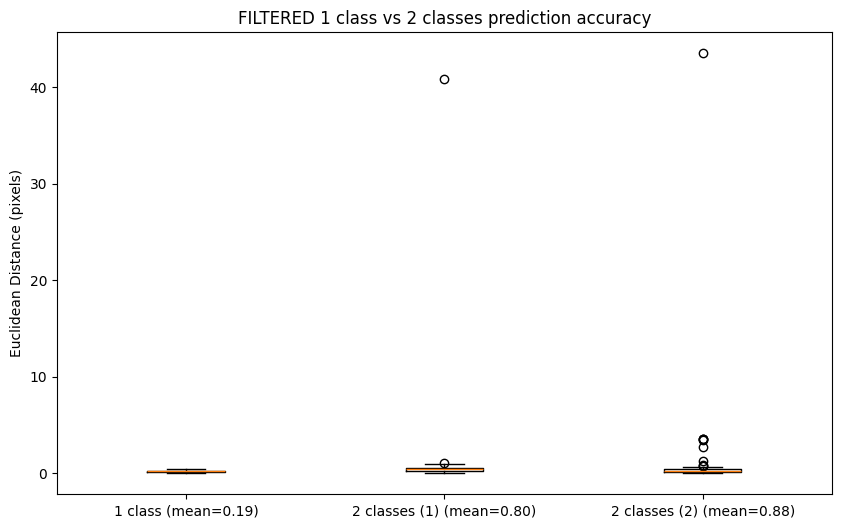

In [43]:
from accuracy_tests import get_euclidean_distance
import matplotlib.pyplot as plt

outputs_C = []
for batch in test_dataloader_C:
    data, *_ = batch
    output = lodestar2_C((data)).detach()
    outputs_C.append(output)

outputs_C = torch.cat(outputs_C, dim=0)

outputs_CE = []
for batch in test_dataloader_CE:
    data, *_ = batch
    output = lodestar2_CE((data)).detach()
    outputs_CE.append(output)

outputs_CE = torch.cat(outputs_CE, dim=0)

ed_1 = get_euclidean_distance(test_dataset_C, result_C, outputs_C, 1)
ed_2 = get_euclidean_distance(test_dataset_CE, result_CE, outputs_CE, 2)

# Reshape the data to 1D arrays
ed_1_reshaped = ed_1.view(100, -1).mean(dim=1).cpu().numpy()
ed_2_a_reshaped = ed_2[:, 0].mean(dim=1).cpu().numpy()
ed_2_b_reshaped = ed_2[:, 1].mean(dim=1).cpu().numpy()

print(ed_2_b_reshaped)
# ed_1_reshaped = ed_1_reshaped[ed_1_reshaped <= 1.5]
# ed_2_a_reshaped = ed_2_a_reshaped[ed_2_a_reshaped <= 1.5]
# ed_2_b_reshaped = ed_2_b_reshaped[ed_2_b_reshaped <= 1.5]

# Combine the lists into a single list for plotting
data_to_plot = [ed_1_reshaped, ed_2_a_reshaped, ed_2_b_reshaped]

# Calculate means
mean_ed_1 = ed_1_reshaped.mean()
mean_ed_2_a = ed_2_a_reshaped.mean()
mean_ed_2_b = ed_2_b_reshaped.mean()


# Create labels with the means
labels = [f'1 class (mean={mean_ed_1:.2f})', 
          f'2 classes (1) (mean={mean_ed_2_a:.2f})', 
          f'2 classes (2) (mean={mean_ed_2_b:.2f})']

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=labels)
plt.title('FILTERED 1 class vs 2 classes prediction accuracy')
plt.ylabel('Euclidean Distance (pixels)')
plt.show()


## Plots

positions1 tensor([23.4140, 76.2860])
positions2 tensor([72.6132, 43.4583])
restult [[23.624   75.96437]
 [72.64533 43.2775 ]]


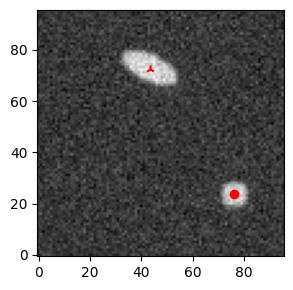

In [87]:
import matplotlib.pyplot as plt

x = 0
print("positions1",positions_CE_C[x])
print("positions2", positions_CE_E[x])
print("restult",result_CE[x])

plt.figure(figsize=(5, 3))
plt.imshow(images_CE[x,...].squeeze(), cmap="gray", origin="lower")
plt.scatter(result_CE[x][0][1], result_CE[x][0][0], c="r", marker='o')
plt.scatter(result_CE[x][1][1], result_CE[x][1][0], c="r", marker='2')
# plt.scatter(result_CE[x][2][1], result_CE[x][2][0], c="r", marker='s')
# plt.scatter(positions_CE_C[x][1], positions_CE_C[x][0], c="b", marker='x', s=20)
# plt.scatter(positions_CE_E[x][1], positions_CE_E[x][0], c="b", marker='x', s=20)
plt.tight_layout()
plt.show()

position tensor([47.3876, 52.9629])
restult [[47.494537 52.942436]]


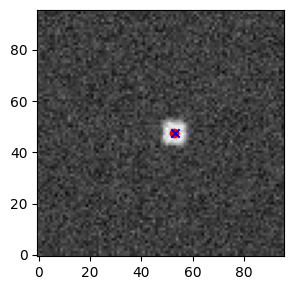

In [46]:
print("position",positions_C[0])
print("restult",result_C[0])

x = 0
plt.figure(figsize=(5, 3))
plt.imshow(images_C[x,...].squeeze(), cmap="gray", origin="lower")
plt.scatter(result_C[x][0][1], result_C[x][0][0], c="r")
plt.scatter(positions_C[x][1], positions_C[x][0], c="b", marker='x')
plt.tight_layout()
plt.show()

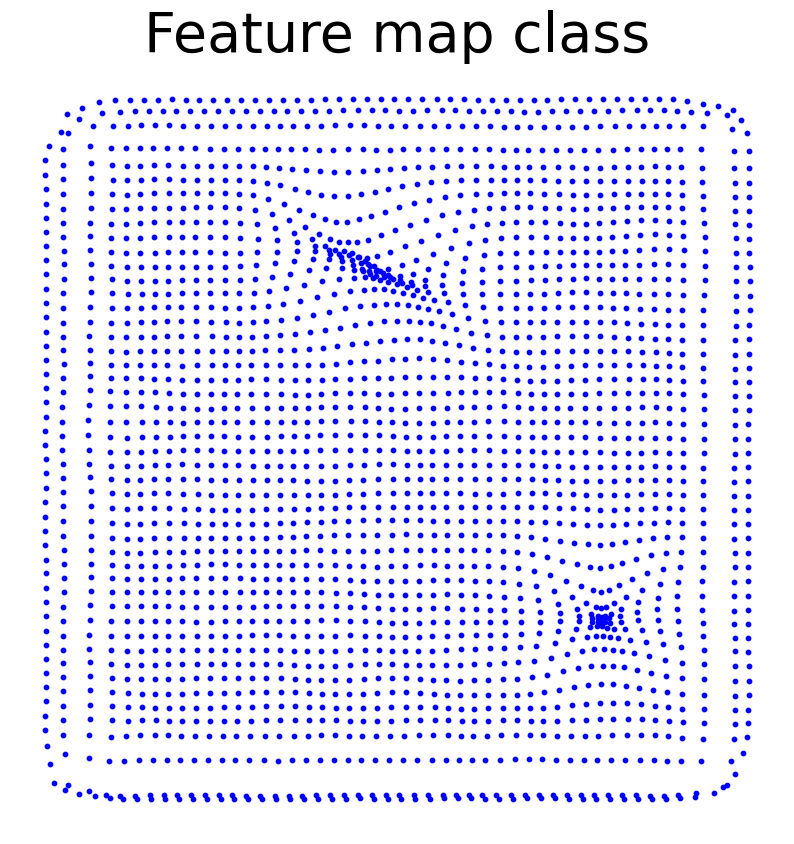

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 48x48 grid of dots
n = 48
x = np.arange(n)
y = np.arange(n)
X, Y = np.meshgrid(x, y)

# Extract the x and y channels (feature map)
F1 = outputs_CE[0, 0, ...].detach().numpy()
F2 = outputs_CE[0, 1, ...].detach().numpy()

# Calculate new positions
Xs = X + F2
Ys = Y + F1

# Create the plot
plt.figure(figsize=(10, 10))
plt.scatter(Xs, Ys, color='blue', s=10)
plt.axis('off')
plt.title('Feature map class', fontsize=40)
plt.show()

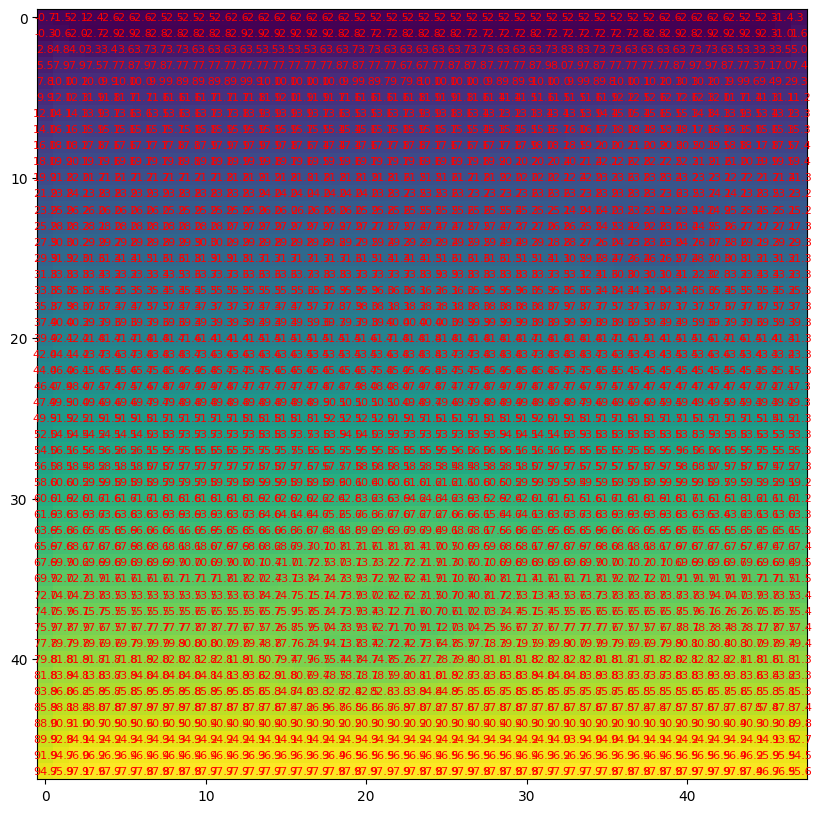

In [80]:
# Extract the x and y channels (feature map)
mask = outputs_CE[0, 5, ...].detach().numpy()
F1 = outputs_CE[0, 0, ...].detach().numpy()
F2 = outputs_CE[0, 1, ...].detach().numpy()

# Calculate new positions
Xs = X + F2*mask
Ys = Y + F1*mask

# Create the plot
plt.figure(figsize=(10, 10))
# plt.scatter(Xs, Ys, color='blue', s=10)
plt.imshow(F1) # *mask
for i in range(F1.shape[0]):
    for j in range(F1.shape[1]):
        value = F1[i, j] #* mask[i, j]
        formatted_value = f'{value:.1f}'.lstrip('0') if value != 0 else '0.0'
        plt.text(j, i, formatted_value, ha='center', va='center', color='red', fontsize=8)
plt.show()

## Hungarian algorithm

In [51]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import scipy.spatial as sc

def compute_matching(lc, pc, distance_threshold=1):
    """
    Computes the matching between ground truth and predicted objects using the Hungarian algorithm,
    considering only the centroid positions (no size/extent involved).

    Parameters:
    lc: np.array - Ground truth centroids
    pc: np.array - Predicted centroids
    distance_threshold: float (optional) - Maximum allowed distance for matching. Pairs with a higher distance are discarded.

    Returns:
    true_positives: int - Count of matched ground truth and prediction centroids
    pairs_dist: np.array - Distances between matched centroids
    false_negatives: int - Number of unmatched ground truth objects (false negatives)
    false_positives: int - Number of unmatched predicted objects (false positives)
    """
    # Compute the distance matrix between centroids (Euclidean distance)
    costd = sc.distance.cdist(lc, pc, metric='euclidean')

    # Solve the linear assignment problem using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(costd)

    # Get distances for the matched pairs
    pairs_dist = costd[row_ind, col_ind]

    # Filter pairs by the distance threshold
    valid_mask = pairs_dist < distance_threshold
    true_positives = np.sum(valid_mask)  # Count of valid matches (true positives)
    filtered_pairs_dist = pairs_dist[valid_mask]  # Distances for valid matches

    # Calculate false negatives (unmatched ground truth) and false positives (unmatched predictions)
    false_negatives = len(lc) - true_positives
    false_positives = len(pc) - true_positives

    return true_positives, filtered_pairs_dist, false_negatives, false_positives


def compute_jaccard_error(true_positives, false_negatives, false_positives):
    """
    Computes the Jaccard index based on the number of matches, false positives, and false negatives.

    Parameters:
    true_positives: int - Number of matched pairs
    false_negatives: int - Number of unmatched ground truth objects
    false_positives: int - Number of unmatched predicted objects

    Returns:
    float - Jaccard index (intersection over union of true positives, false positives, and false negatives)
    """
    intersection = true_positives
    union = true_positives + false_negatives + false_positives

    if union == 0:
        return 1.0  # No objects in ground truth or prediction, Jaccard index is 1

    return intersection / union

In [52]:
lc = np.array([[0, 0], [1, 1], [2, 2]])  # Ground truth centroids
pc = np.array([[0, 0], [1.2, 1.2], [10, 10]])  # Predicted centroids

true_positives, pairs_dist, false_negatives, false_positives = compute_matching(lc, pc, distance_threshold=1)
jaccard_error = compute_jaccard_error(true_positives, false_negatives, false_positives)

print(f"True Positives: {true_positives}")
print(f"Distances of Matched Pairs: {pairs_dist}")
print(f"False Negatives: {false_negatives}")
print(f"False Positives: {false_positives}")
print(f"Jaccard Index: {jaccard_error}")

True Positives: 2
Distances of Matched Pairs: [0.         0.28284271]
False Negatives: 1
False Positives: 1
Jaccard Index: 0.5


In [23]:
result_C = lodestar2_C.detect(images_C)
result_CE = lodestar2_CE.detect(images_CE)

In [ ]:
import matplotlib.pyplot as plt

outputs_C = []
for batch in test_dataloader_C:
    data, *_ = batch
    output = lodestar2_C((data)).detach()
    outputs_C.append(output)

outputs_C = torch.cat(outputs_C, dim=0)

outputs_CE = []
for batch in test_dataloader_CE:
    data, *_ = batch
    output = lodestar2_CE((data)).detach()
    outputs_CE.append(output)

outputs_CE = torch.cat(outputs_CE, dim=0)

In [46]:
# Hungarian algorithms for one object
# lc (np ground truth centroids)
positions = [item[-1:] for item in test_dataset_C]
positions = [torch.stack(item) for item in positions]
positions = torch.stack(positions)
positions = positions.numpy()
positions = positions.squeeze()

# pc (np predicted centroids)
result_C_np = np.vstack(result_C)

# li (np ground truth indices)
li = np.arange(1, 101)

# pi (np predicted indices)
pi = np.arange(1, len(result_C_np)+1)

# Hungarian algorithm
pairs, pairs_dist = compute_matching(positions, result_C_np, li, pi, distance_threshold=1.0)
print("Matched Pairs:", pairs)
print("Centroid Distances for Matches:", pairs_dist)

# Compute Jaccard error
jaccard_error = compute_jaccard_error(pairs, li, pi)
print("Jaccard Error:", jaccard_error)

Matched Pairs: [[  1   1]
 [  2   2]
 [  3   3]
 [  4   4]
 [  5   5]
 [  6   6]
 [  7   7]
 [  8   8]
 [  9   9]
 [ 10  10]
 [ 11  11]
 [ 12  12]
 [ 13  13]
 [ 14  14]
 [ 15  15]
 [ 16  16]
 [ 17  17]
 [ 18  18]
 [ 19  19]
 [ 20  20]
 [ 21  21]
 [ 22  22]
 [ 23  23]
 [ 24  24]
 [ 25  25]
 [ 26  26]
 [ 27  27]
 [ 28  28]
 [ 29  29]
 [ 30  30]
 [ 31  31]
 [ 32  32]
 [ 33  33]
 [ 34  34]
 [ 35  35]
 [ 36  36]
 [ 37  37]
 [ 38  38]
 [ 39  39]
 [ 40  40]
 [ 41  41]
 [ 42  42]
 [ 43  43]
 [ 44  44]
 [ 45  45]
 [ 46  46]
 [ 47  47]
 [ 48  48]
 [ 49  49]
 [ 50  50]
 [ 51  51]
 [ 52  52]
 [ 53  53]
 [ 54  54]
 [ 55  55]
 [ 56  56]
 [ 57  57]
 [ 58  58]
 [ 59  59]
 [ 60  60]
 [ 61  61]
 [ 62  62]
 [ 63  63]
 [ 64  64]
 [ 65  65]
 [ 66  66]
 [ 67  67]
 [ 68  68]
 [ 69  69]
 [ 70  70]
 [ 71  71]
 [ 72  72]
 [ 73  73]
 [ 74  74]
 [ 75  75]
 [ 76  76]
 [ 77  77]
 [ 78  78]
 [ 79  79]
 [ 80  80]
 [ 81  81]
 [ 82  82]
 [ 83  83]
 [ 84  84]
 [ 85  85]
 [ 86  86]
 [ 87  87]
 [ 88  88]
 [ 89  89]
 [ 90 